In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ssl
from datasets import MNISTDataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

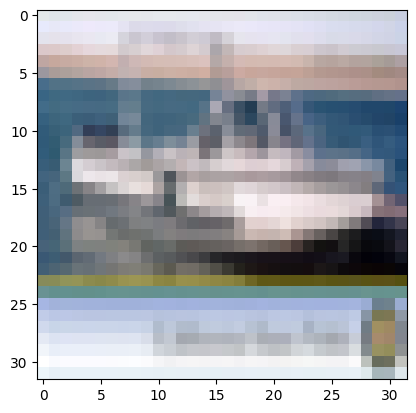

[8]


ValueError: cannot reshape array of size 153600000 into shape (784)

In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# we can look at any of the images and the corresponding labels
# say, image no. 155
plt.imshow(train_images[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

# images are "flattened" into vectors
data = MNISTDataset(train_images.reshape([-1, 28*28]), train_labels,
                    test_images.reshape([-1, 28*28]), test_labels,
                    batch_size=128)

In [315]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [316]:
# define the linear model
# weight dimensions are completely determined by input/output dimensions
W = tf.Variable(np.random.normal(size=(28*28, 144)),dtype=np.float32, low=-0.1, high=0.1)
b = tf.Variable(np.zeros(144), dtype=np.float32)

W1 = tf.Variable(np.random.normal(size=(144, 10)),dtype=np.float32, low=-0.1, high=0.1)
b1 = tf.Variable(np.zeros(10), dtype=np.float32)

weights=[W, W1, b,b1
    ]


#model with 1 hidden layers
def model(inputs):
    
    #hidden layer 1
    # h1_o = tf.nn.relu((tf.matmul(inputs,W)+b))
    h1_o = tf.nn.relu(tf.matmul(inputs,W)+b)

    # #hidden layer 2
    # h2_o=  tf.nn.relu((tf.matmul(h1_o,W1)+b1))
    # #h2_o=  (tf.matmul(h1_o,W1)+b1)

    #output
    o=  tf.nn.softmax((tf.matmul(h1_o,W1)+b1))
    #o= (tf.matmul(h2_o,W2)+b2)
    return o


def get_accuracy(labels, outputs):
    predictions = tf.argmax(outputs, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))



# NOTE
# the ONLY thing that you should have to change for a working MLP is to
# - add more variables
# - adapt the model function (don't forget activation functions)
#   - activation functions can be found mainly in the tf.nn module,
#     e.g. tf.nn.relu
# - add the new variables in the gradient call/update below


# parameters for the training process
# this already offers potential for experimentation
# - how many steps do we actually need to reach acceptable performance?
# - what if we train for some absurd number of steps?: still would be stuck in local minima if there are no learnable gradients
# - what happens if we increase/decrease the learning rate?: might converge faster or slower
# - do learning rate and number of steps interact?
# - ...
train_steps = 2000
learning_rate = 0.505

In [317]:
W.shape

TensorShape([784, 144])

In [318]:
# training loop
plot_test=[]
plot_accuracy=[]
plot_steps=[]
for step in range(train_steps+1):
    image_batch, label_batch = data.next_batch()

    with tf.GradientTape() as tape:
        logits = model(image_batch)
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=label_batch))

    grads = tape.gradient(cross_entropy, weights)
    W.assign_sub(learning_rate * grads[0])
    W1.assign_sub(learning_rate * grads[1])

    b.assign_sub(learning_rate * grads[2])
    b1.assign_sub(learning_rate * grads[3])

    # every so often we print loss/accuracy
    if not step % 100:
        accuracy = get_accuracy(label_batch, logits)
        print("Step {}. Batch loss: {} Batch accuracy: {}".format(step+1, cross_entropy, accuracy))
        plot_accuracy.append(accuracy)
        plot_steps.append(step+1)

        test_logits = model(data.test_data)
        test_accuracy = get_accuracy(data.test_labels, test_logits)
        print("Test accuracy: {}".format(test_accuracy))
        plot_test.append(test_accuracy)


Step 1. Batch loss: 2.3819527626037598 Batch accuracy: 0.078125
Test accuracy: 0.06269999593496323
Step 101. Batch loss: 2.1944611072540283 Batch accuracy: 0.265625
Test accuracy: 0.23909999430179596
Step 201. Batch loss: 2.209768772125244 Batch accuracy: 0.25
Test accuracy: 0.29409998655319214
Step 301. Batch loss: 2.1481306552886963 Batch accuracy: 0.3125
Test accuracy: 0.31939998269081116
Step 401. Batch loss: 2.1215696334838867 Batch accuracy: 0.3359375
Test accuracy: 0.37070000171661377
Starting new epoch...
Step 501. Batch loss: 2.131535291671753 Batch accuracy: 0.328125
Test accuracy: 0.40070000290870667
Step 601. Batch loss: 2.1314096450805664 Batch accuracy: 0.3359375
Test accuracy: 0.4105999767780304
Step 701. Batch loss: 2.132390260696411 Batch accuracy: 0.328125
Test accuracy: 0.4099999964237213
Step 801. Batch loss: 2.0326602458953857 Batch accuracy: 0.4296875
Test accuracy: 0.4226999878883362
Step 901. Batch loss: 2.038821220397949 Batch accuracy: 0.421875
Test accuracy: 

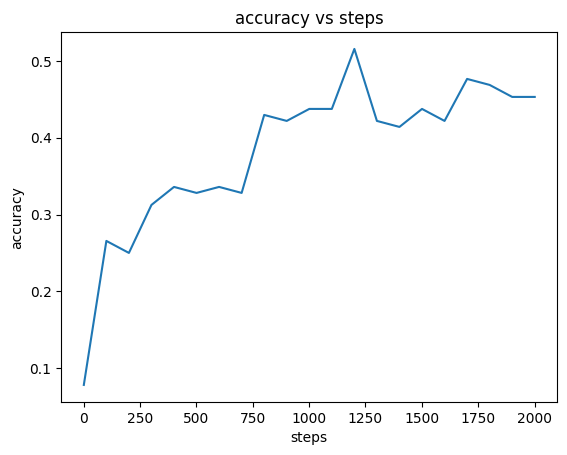

In [319]:


plt.title("accuracy vs steps") 
plt.xlabel("steps") 
plt.ylabel("accuracy") 
plt.plot(plot_steps,plot_accuracy) 

plt.show()

In [320]:
test_predictions = tf.argmax(model(data.test_data), axis=1,
                       output_type=tf.int32)
test_accuracy = tf.reduce_mean(tf.cast(tf.equal(test_predictions, data.test_labels),
                             tf.float32))
print("Test accuracy: {}".format(test_accuracy))


Test accuracy: 0.44209998846054077


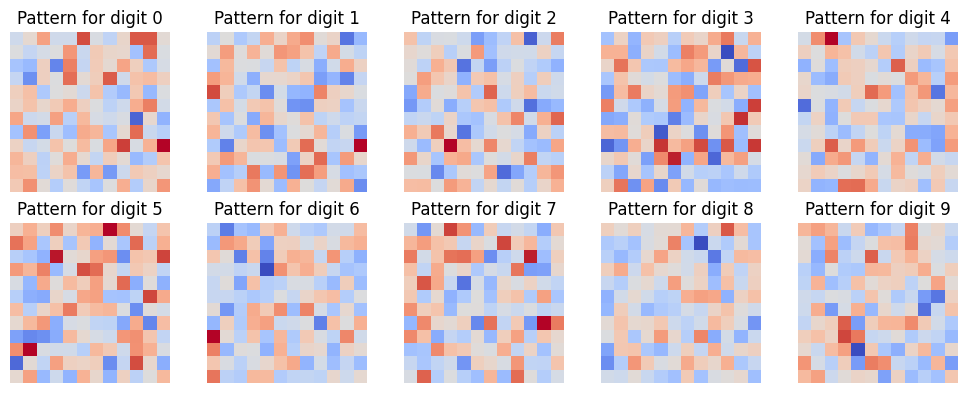

In [321]:
# some rudimentary visualization.
# in a  linear model, the weights basically learn one pattern per class.
# the patterns are compared to the input and the pattern with the highest matching score
# (dot product) "wins".
# we can plot the pattern learned for each class as an image.
# they don't always look as expected :)

plt.figure(figsize=(10, 4))
for ind, pattern in enumerate(W1.numpy().T):
    pattern = pattern.reshape((12, 12))

    absmax = abs(pattern).max()
    plt.subplot(2, 5, ind+1)
    plt.imshow(pattern, vmin=-absmax, vmax=absmax, cmap="coolwarm")
    plt.axis("off")
    plt.title("Pattern for digit {}".format(ind))
plt.tight_layout()
plt.show()

In [322]:
# define the linear model
# weight dimensions are completely determined by input/output dimensions
W = tf.Variable(np.random.normal(size=(28*28, 28*28),scale=0.1),dtype=np.float32)
b = tf.Variable(np.zeros(28*28), dtype=np.float32)

W1 = tf.Variable(np.random.normal(size=(28*28, 144), scale=0.1),dtype=np.float32)
b1 = tf.Variable(np.zeros(144), dtype=np.float32)

W2 = tf.Variable(np.random.normal(size=(144, 10), scale=0.1),dtype=np.float32)
b2 = tf.Variable(np.zeros(10), dtype=np.float32)

weights_2=[W,W1,W2, b,b1, b2]


#model with 2 hidden layers
def model_2(inputs):
    
    #hidden layer 1
    # h1_o = tf.nn.relu((tf.matmul(inputs,W)+b))
    h1_o = tf.nn.relu(tf.matmul(inputs,W)+b)

    #hidden layer 2
    h2_o=  tf.nn.relu((tf.matmul(h1_o,W1)+b1))
    # #h2_o=  (tf.matmul(h1_o,W1)+b1)

    #output
    o=  tf.nn.softmax((tf.matmul(h2_o,W2)+b2))
    #o= (tf.matmul(h2_o,W2)+b2)
    return o

# training loop

plot_accuracy=[]
plot_steps=[]
for step in range(train_steps+1):
    image_batch, label_batch = data.next_batch()

    with tf.GradientTape() as tape:
        logits = model_2(image_batch)
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=label_batch))

    grads = tape.gradient(cross_entropy, weights_2)
    W.assign_sub(learning_rate * grads[0])
    W1.assign_sub(learning_rate * grads[1])
    W2.assign_sub(learning_rate * grads[2])

    b.assign_sub(learning_rate * grads[3])
    b1.assign_sub(learning_rate * grads[4])
    b2.assign_sub(learning_rate * grads[5])

    # every so often we print loss/accuracy
    if not step % 100:
        accuracy = get_accuracy(label_batch, logits)
        print("Step {}. Batch loss: {} Batch accuracy: {}".format(step+1, cross_entropy, accuracy))

        test_logits = model_2(data.test_data)
        test_accuracy = get_accuracy(data.test_labels, test_logits)
        print("Test accuracy: {}".format(test_accuracy))
        plot_test.append(test_accuracy)
        plot_accuracy.append(accuracy)
        plot_steps.append(step+1)



Step 1. Batch loss: 2.327671527862549 Batch accuracy: 0.0390625
Test accuracy: 0.14499999582767487
Step 101. Batch loss: 1.9232757091522217 Batch accuracy: 0.546875
Test accuracy: 0.4989999830722809
Step 201. Batch loss: 1.969639539718628 Batch accuracy: 0.4921875
Test accuracy: 0.5098000168800354
Step 301. Batch loss: 1.9635822772979736 Batch accuracy: 0.5078125
Test accuracy: 0.5273000001907349
Starting new epoch...
Step 401. Batch loss: 1.899118185043335 Batch accuracy: 0.5546875
Test accuracy: 0.5288000106811523
Step 501. Batch loss: 1.9909807443618774 Batch accuracy: 0.46875
Test accuracy: 0.5236999988555908
Step 601. Batch loss: 1.9505691528320312 Batch accuracy: 0.5078125
Test accuracy: 0.5224999785423279
Step 701. Batch loss: 1.855787754058838 Batch accuracy: 0.59375
Test accuracy: 0.5303999781608582
Step 801. Batch loss: 1.900590181350708 Batch accuracy: 0.5625
Test accuracy: 0.5354999899864197
Starting new epoch...
Step 901. Batch loss: 1.913835048675537 Batch accuracy: 0.546

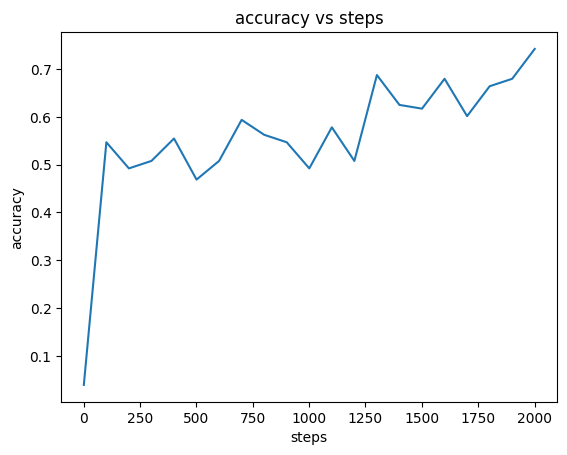

In [323]:
import numpy as np 
from matplotlib import pyplot as plt 

x = np.arange(1,11) 
y = 2 * x + 5 
plt.title("accuracy vs steps") 
plt.xlabel("steps") 
plt.ylabel("accuracy") 
plt.plot(plot_steps,plot_accuracy) 
plt.show()

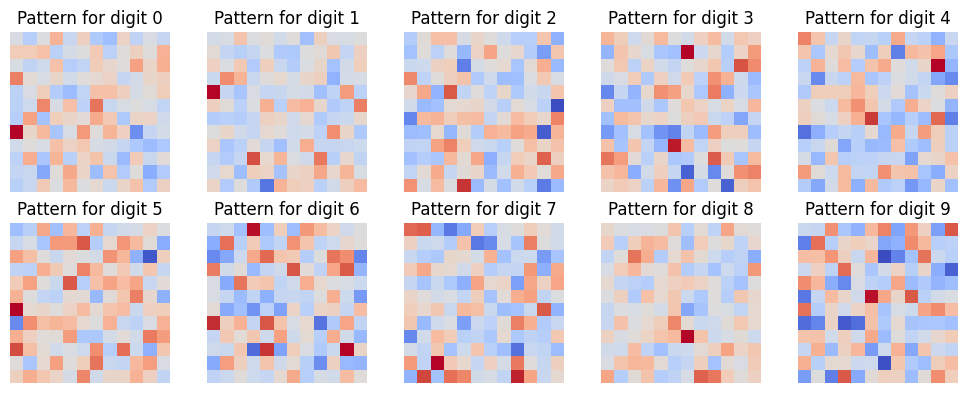

In [324]:
plt.figure(figsize=(10, 4))
for ind, pattern in enumerate(W2.numpy().T):
    pattern = pattern.reshape((12, 12))

    absmax = abs(pattern).max()
    plt.subplot(2, 5, ind+1)
    plt.imshow(pattern, vmin=-absmax, vmax=absmax, cmap="coolwarm")
    plt.axis("off")
    plt.title("Pattern for digit {}".format(ind))
plt.tight_layout()
plt.show()